Wykresy:

1) Dystrybucja - violin, boxplot, densityplot, histogram

2) Rozkłąd kilku zmiennych - scatter, bubble-scatter, heatmap, correlogram, densityplot

3) Rankingi - barplot, lolipop plot, spider, parallellines

4) Część całości - stacked barplot, donut plot, pie chart, treemap, dendrogram, venn diagram

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import math
import re
from matplotlib.patches import Patch
import bokeh
import squarify

In [4]:
#usuwam wiodącą spację z datasetu - śmieć, który się ostał po webscrappingu; zmieniam błędną nazwę ostatniej kolumny
df=pd.read_csv('H3Units.csv')
df.replace(to_replace =' ', value='', regex=True, inplace=True)
print(df.at[2,'Unit_name'])
df['Special_abilities']=df['Special Ablility']
del df['Special Ablility']
df.loc[df['Special_abilities'].isna(),'Special_abilities']='-'

Archer


In [5]:
k=df['Unit_name'].str.contains('Dragon$')
df[k]

,Unit_name,Castle,Level,Attack,Defence,Minimum Damage,Maximum Damage,Health,Speed,Growth,AI_Value,Gold,Additional_item,Special_abilities
26,GreenDragon,Rampart,7,18,18,40,50,180,10,1,4872,2400,"Crystal,1","Flying,Breathattack,Resistlvl1–3spells"
27,GoldDragon,Rampart,7+,27,27,40,50,250,16,1,8613,4000,"Crystal,2","Flying,Breathattack,Resistlvl1–4spells"
68,BoneDragon,Necropolis,7,17,15,25,50,150,9,1,3388,1800,0,"Dragon,Undead,Flying,Morale-1"
69,GhostDragon,Necropolis,7+,19,17,25,50,200,14,1,4696,3000,"Mercury,1","Dragon,Undead,Flying,Morale-1,Aging"
82,RedDragon,Dungeon,7,19,19,40,50,180,11,1,4702,2500,"Sulfur,1","Dragon,Flying,Breathattack,Resistlvl1-3spells"
83,BlackDragon,Dungeon,7+,25,25,40,50,300,15,1,8721,4000,"Sulfur,2","Dragon,Flying,Breathattack,Resistallspells,Hat..."
137,FaerieDragon,Neutral,7,20,20,20,30,500,15,1,19580,10000,"Gem,8","Dragon,Flying,Spellcaster,MagicMirror"
138,RustDragon,Neutral,7,30,30,50,50,750,17,1,26433,15000,"Sulfur,14","Dragon,Flying,Breath,Acidbreath"
139,CrystalDragon,Neutral,7,40,40,60,75,800,16,1,39338,20000,"Crystal,10","Dragon,Crystalgeneration,Resistance+20%,Unliving"
140,AzureDragon,Neutral,7,50,50,70,80,1000,19,1,78845,30000,"Mercury,20","Dragon,Flying,Breath,Fear,Resistlvl1–3spells,R..."


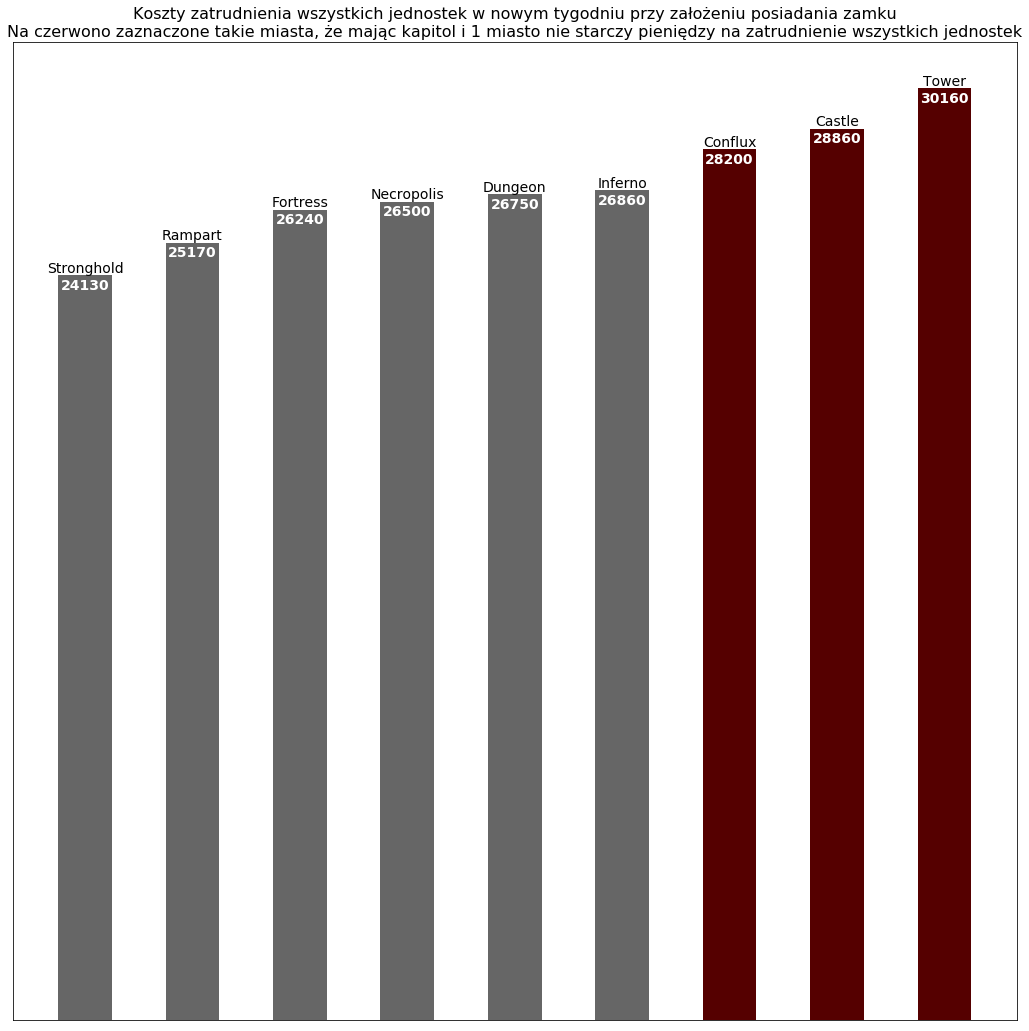

In [6]:
#ranking #1 - Barplot - zsumowane koszty zatrudnienia wszystkich jednostek w nowym tygodniu - założenie posiadania Zamku
df2=df.copy()
df2['All']=df2['Growth']*df2['Gold']*2
k=df2['Level'].str.contains('\+')
df2=df2[k]
df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='All')

fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)

cncs=df2.columns.get_loc('Castle')
cnal=df2.columns.get_loc('All')
for i in range(0, df2.shape[0], 1):
    Z=df2.iat[i, cnal]
    if (Z<28000):
        ax.bar(x=i, height=Z, color='#666666', width=0.5)
    else:
        ax.bar(x=i, height=Z, color='#550000', width=0.5)
    ax.text(x=i, y=Z-100, s=str(Z), horizontalalignment='center', verticalalignment='top', fontsize=14, color='white', weight='bold')
    ax.text(x=i, y=Z, s=df2.iat[i, cncs], horizontalalignment='center', verticalalignment='bottom', fontsize=14)

#ax.axis('off')
ax.get_yaxis().set_visible(False)
ax.set_xticks([])
ax.set_title('Koszty zatrudnienia wszystkich jednostek w nowym tygodniu przy założeniu posiadania zamku\nNa czerwono zaznaczone takie miasta, że mając kapitol i 1 miasto nie starczy pieniędzy na zatrudnienie wszystkich jednostek', fontsize=16)

plt.show()

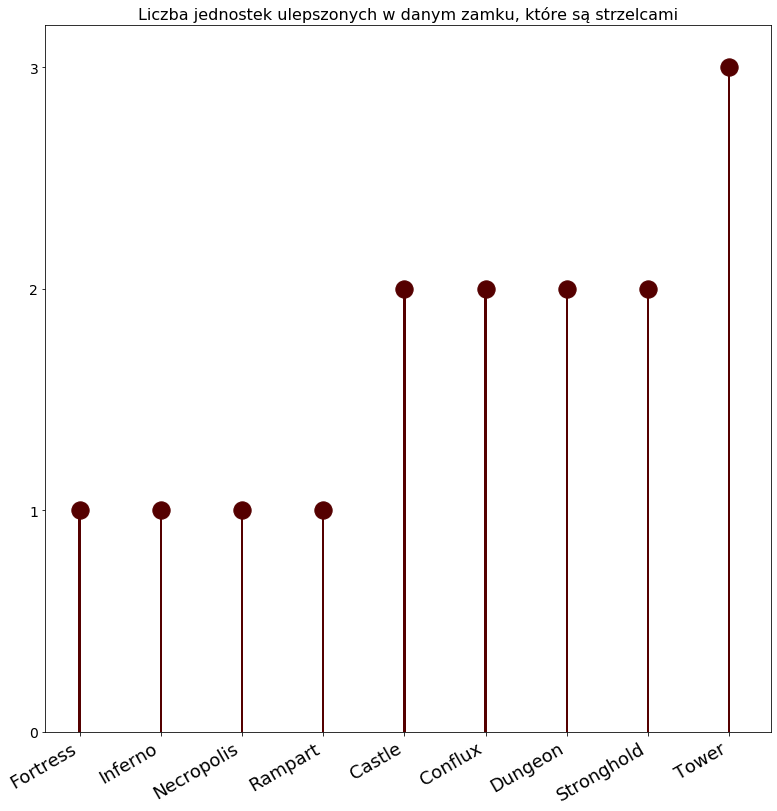

In [7]:
#ranking #2 - lolipop plot - barchart wąski z oznaczonym kropką końcem


df2=df.copy()
k=df2['Special_abilities'].str.contains('Ranged\(')
l=df2['Level'].str.contains('\+')

df2=df2[k&l]
df2['All']=1
df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='All')


fig, ax=plt.subplots(1,1)
fig.set_size_inches(13,13)

f=df2.columns.get_loc('All')
for i in range(df2.shape[0]):
    Z=df2.iat[i,f]
    ax.bar(x=i, height=Z, width=0.03, color='#550000')
    ax.scatter(x=i, y=Z, color='#550000', s=300.1)

ax.set_xticks(range(0,9,1))
ax.set_yticks(range(0,4,1))
ax.set_xticklabels(df2['Castle'], ha='right')
ax.xaxis.set_tick_params(labelsize=18, labelrotation=30)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title('Liczba jednostek ulepszonych w danym zamku, które są strzelcami', fontsize=16)
#plt.grid(axis='y')

plt.show()

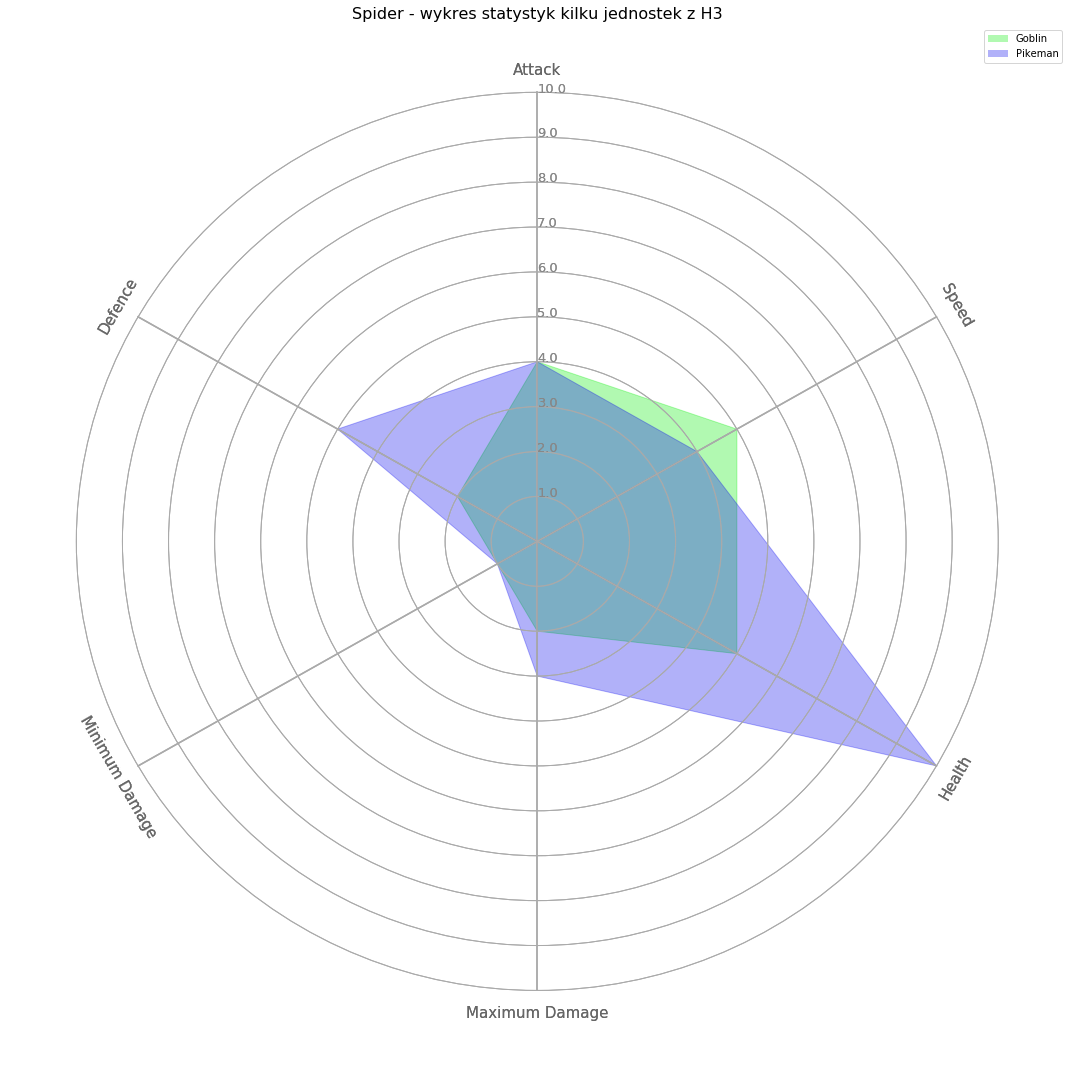

In [8]:
#ranking #3 - Spider

#allez-promień koła, n-liczba promieni radara, m-licba kółek, maxi-najwyższa liczba na radarze, subd-ciąg z labelami, ax-wykres, incol-kolor żłoba, legg-legenda, lab-label
def spiderland(allez, n, m, maxi, subd, ax, incol='#EE0000', legg=[], lab='Nan'):
    #Dodanie do legendy nowego obiektu
    legg.append(Patch(facecolor=incol, alpha=0.3, label=lab))
    
    deg=2*math.pi/n
    x=[0]*n
    y=[allez]*n

    #punkty końca linii radaru
    for i in range(1, n, 1):
        x[i]=x[i-1]*math.cos(deg)-y[i-1]*math.sin(deg)
        y[i]=x[i-1]*math.sin(deg)+y[i-1]*math.cos(deg)

    #Radar
    for i in range(n):
        ax.plot([0, x[i]], [0, y[i]], color='#AAAAAA')

    #Wypełnienie trójkątów
    i=1
    while (i<n):
        ax.fill([0, x[i-1]*int(subd[i-1])/maxi, x[i]*int(subd[i])/maxi], [0, y[i-1]*int(subd[i-1])/maxi, y[i]*int(subd[i])/maxi], alpha=0.3, color=incol)
        i+=1
    ax.fill([0, x[i-1]*int(subd[i-1])/maxi, x[0]*int(subd[0])/maxi], [0, y[i-1]*int(subd[i-1])/maxi, y[0]*int(subd[0])/maxi], alpha=0.3, color=incol)

    #Tekst labeli na kresie spidera
    for i in range(n):
        roth=i*deg*(180/math.pi)
        if (roth>90 and roth<270):
            roth=180+roth
        ax.text(x=x[i]*1.05, y=y[i]*1.05, s=subd.index[i], fontsize=15, color='#666666', rotation=roth, horizontalalignment='center', verticalalignment='center')


    #Kręgi
    crc=[0]*m
    for i in range(m):
        crc[i]=plt.Circle((0,0), allez*(i+1)/m, color='#AAAAAA', fill=None)
        ax.add_artist(crc[i])
        ax.text(x=0, y=allez*(i+1)/m, s=str(maxi*(i+1)/m), fontsize=13, color='#888888')

    ax.set_xlim(-2.3, 2.3)
    ax.set_ylim(-2.3, 2.3)

fig, ax=plt.subplots(1,1)
fig.set_size_inches(19, 19)

leggy=[]
spiderland(2, 6, 10, 10, df[df['Unit_name']=='Goblin'].iloc[0,3:9], ax, incol='#00EE00', legg=leggy, lab='Goblin')
spiderland(2, 6, 10, 10, df[df['Unit_name']=='Pikeman'].iloc[0,3:9], ax, incol='#0000EE', legg=leggy, lab='Pikeman')
ax.legend(handles=leggy)
ax.set_title('Spider - wykres statystyk kilku jednostek z H3', fontsize=16)
ax.axis('off')

plt.show()

#print(df[df['Unit_name']=='Gnoll'].iloc[0,:][2:7])

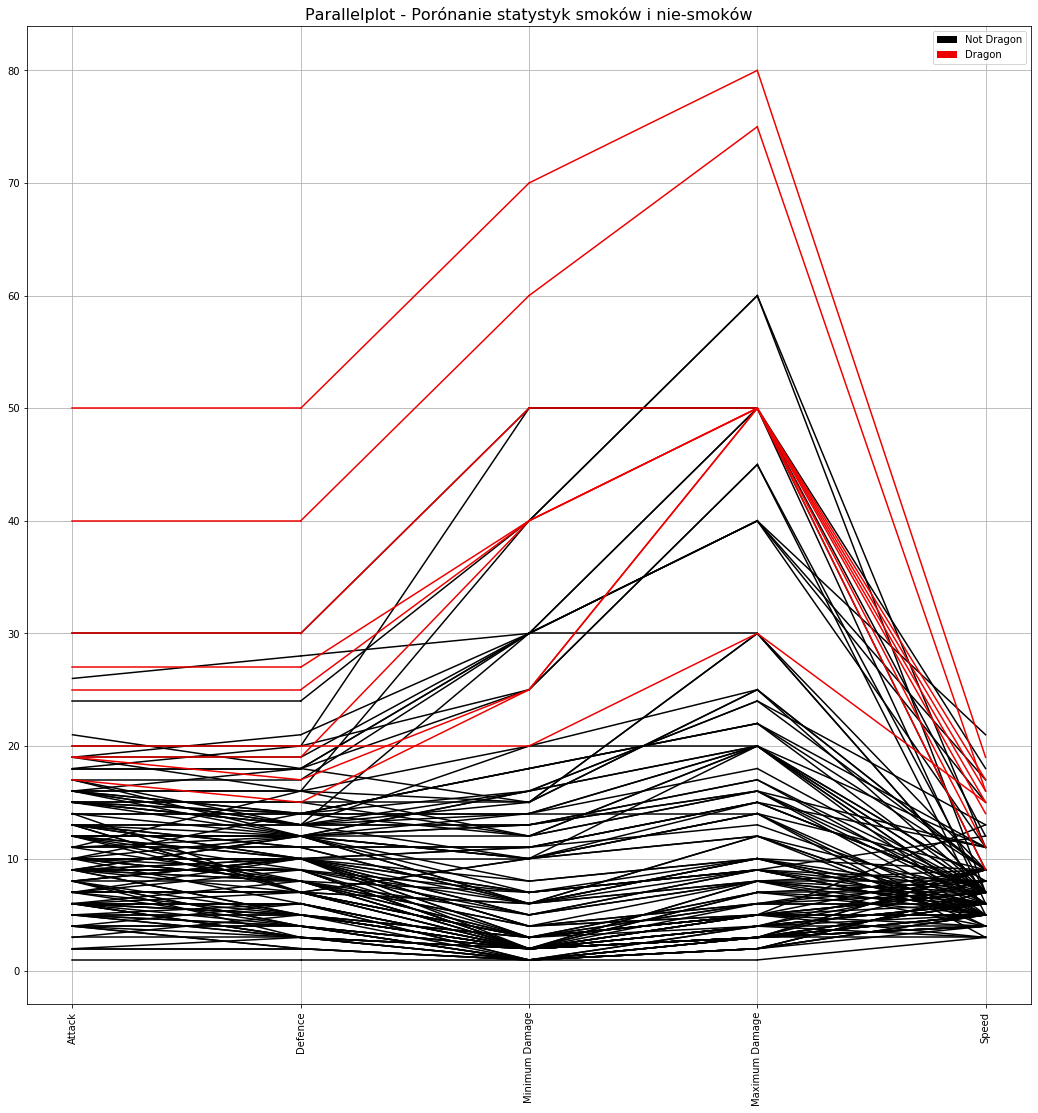

In [9]:
#ranking #4 - parallelplots - lepszy od spidera, bo zamiast współrzędnych polarnych są kartezyańskie
#Pozwala pokazywać dane w dowolnie wysokim wymiarze (podobnie jak spider)
def drawparallels(ax, subd, legg=[], lab='', incol='#EE0000'):
    for j in range(1, subd.shape[0], 1):
        for i in range(1, subd.shape[1], 1):
            ax.plot([i-1, i], [subd.iloc[j,i-1], subd.iloc[j,i]], color=incol)
    
    legg.append(Patch(facecolor=incol, label=lab)) 
    ax.set_xticks(range(0, subd.shape[1], 1))
    ax.set_xticklabels(subd.columns)
    ax.xaxis.set_tick_params(labelrotation=90)


fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)
colors=['#EE0000', '#888800', '#990044', '#EE0088', '#0000EE', '#00EE88', '#000000']
lg=[]

#komentarz - parallelplot z poziomami
#for i in range(1, 8, 1):
#    mdf=df[(df['Level']==str(i)) | (df['Level']==str(i)+'+')].iloc[:,[3,4,5,6,8]]
#    drawparallels(ax, mdf, legg=lg, lab=str(i), incol=colors[i-1])

#print(df[(df['Level']==str(i)) | (df['Level']==str(i)+'+')])


k=df['Unit_name'].str.contains('Dragon$')
k[k.isna()]=False
k=k.astype('bool')

mdf=df[np.invert(k)].iloc[:,[3,4,5,6,8]]
drawparallels(ax, mdf, legg=lg, lab='Not Dragon', incol=colors[6])
mdf=df[k].iloc[:,[3,4,5,6,8]]
drawparallels(ax, mdf, legg=lg, lab='Dragon', incol=colors[0])

ax.legend(handles=lg)
ax.set_title('Parallelplot - Porónanie statystyk smoków i nie-smoków', fontsize=16)
ax.grid()
plt.show()

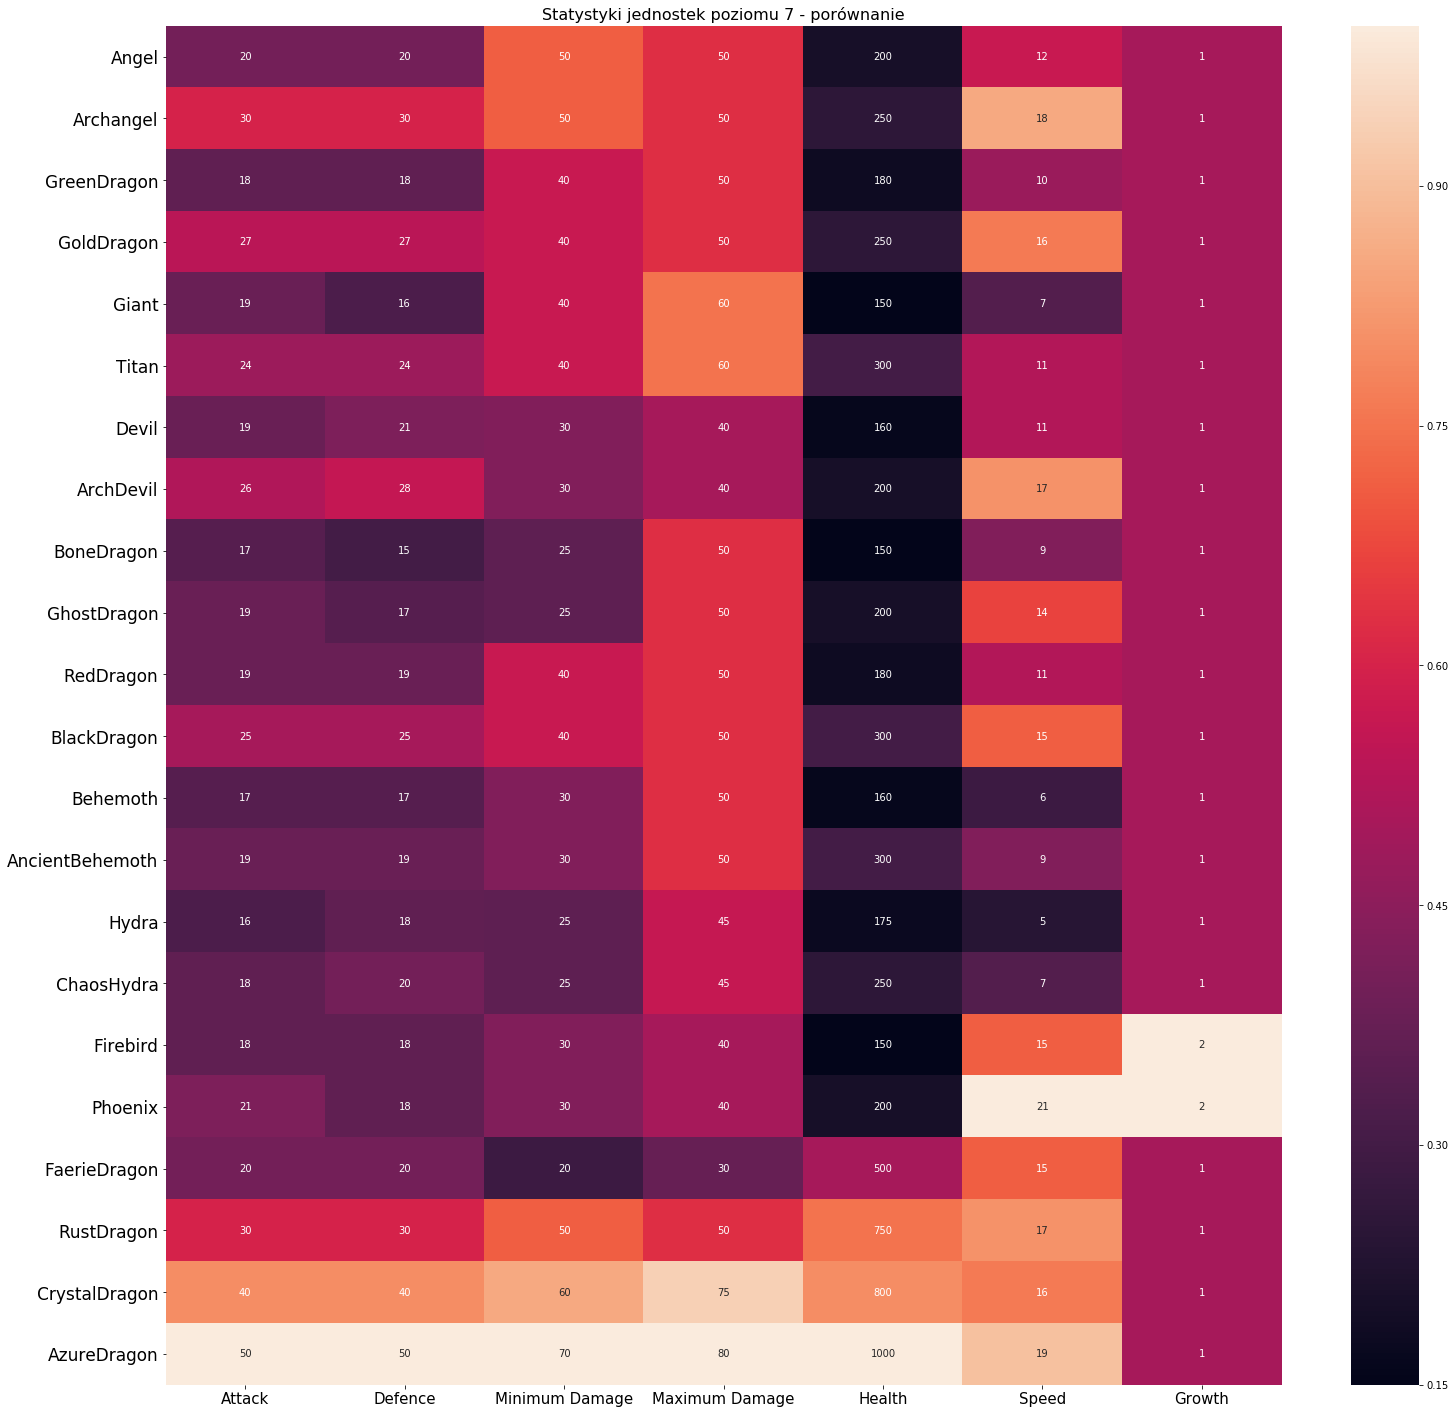

In [10]:
#Dystrybucja #3 - heatmap z normalizacją (proporcje z przedziału 0-1)
#legenda pokazuje proporcje (Im jaśniej, tym większa wartość w kolumnie)
def besserheatmap(df, ax, labels=2.312, ant=False):
    for i in range(0, df.shape[1], 1):
        mn=df.iloc[:,i].max()
        df.iloc[:,i]=df.iloc[:,i]/mn
    
    sns.heatmap(data=df, ax=ax, annot=ant, fmt='d')
    ax.yaxis.set_tick_params(labelrotation=0, labelsize=17)
    ax.xaxis.set_tick_params(labelrotation=0, labelsize=15)
    ax.set_ylim(df.shape[0], 0)
    
    x=[0.5]*df.shape[0]
    for i in range(1, len(x), 1):
        x[i]=x[i-1]+1
    ax.set_yticks(x)
    ax.set_ylim(df.shape[0], 0)
    
    if (str(type(labels))!="<class 'float'>"):
        ax.set_yticklabels(labels)
    
    

fig, ax=plt.subplots(1,1)
fig.set_size_inches(25,25)

df2=df[(df['Level']=='7') | (df['Level']=='7+')]
GG=df2.loc[:,df.dtypes=='int64']
lGG=df2.loc[:,'Unit_name']
GG=GG.iloc[:,0:7]

besserheatmap(df=GG, ax=ax, labels=lGG, ant=GG.copy())
ax.set_title('Statystyki jednostek poziomu 7 - porównanie', fontsize=16)

plt.show()

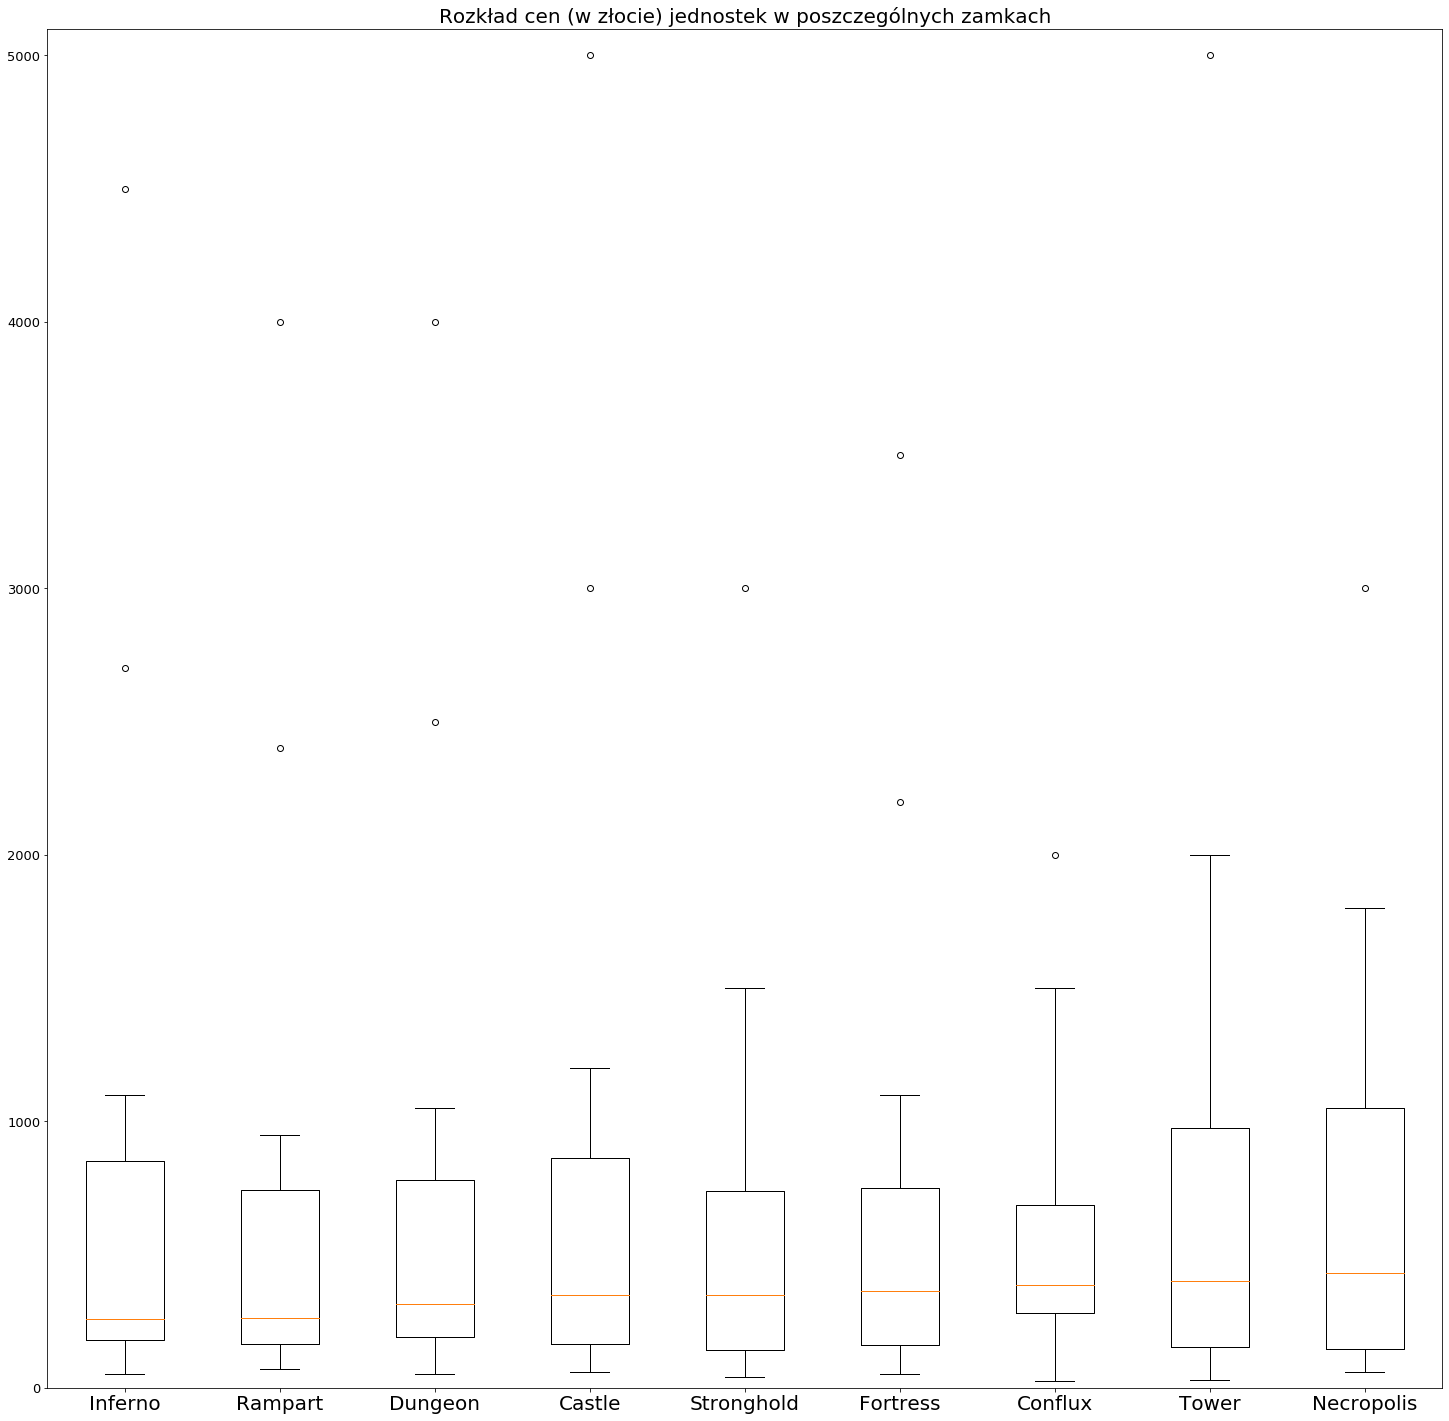

In [60]:
#Dystrybucja #1 - boxplot - rozkład cen (w złocie) jednostek w poszczególnych zamkach - po 1 każdego rodzaju (po 14 obserwacji w 1 kolumnie)
#Boxplot: linia środkowa - mediana, box to odstęp pomiędzy I i III kwartylem, warkocz to min(max_obs, Q3+IQR*2) i max(min_obs, Q1-IQR*2) gdzie IQR - rozstęp międzykwartylowy
df2=df.loc[:,['Castle', 'Gold']]
df3=df2.groupby(['Castle'], as_index=False).median().sort_values(by='Gold')
k=df3['Castle']
k=k[k!='Neutral']

"""
k=np.unique(df['Castle'])
k=k[k!='Neutral']"""
l1=[0]*len(k)
for i in range(len(k)):
    l1[i]=df2[df2['Castle']==k[k.index[i]]].loc[:,'Gold']

fig, ax=plt.subplots(1,1)
fig.set_size_inches(25,25)
ax.boxplot(l1, labels=k, whis=2)
ax.set_ylim(0, 5100)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=13)
ax.set_title('Rozkład cen (w złocie) jednostek w poszczególnych zamkach', fontsize=20)
plt.show()

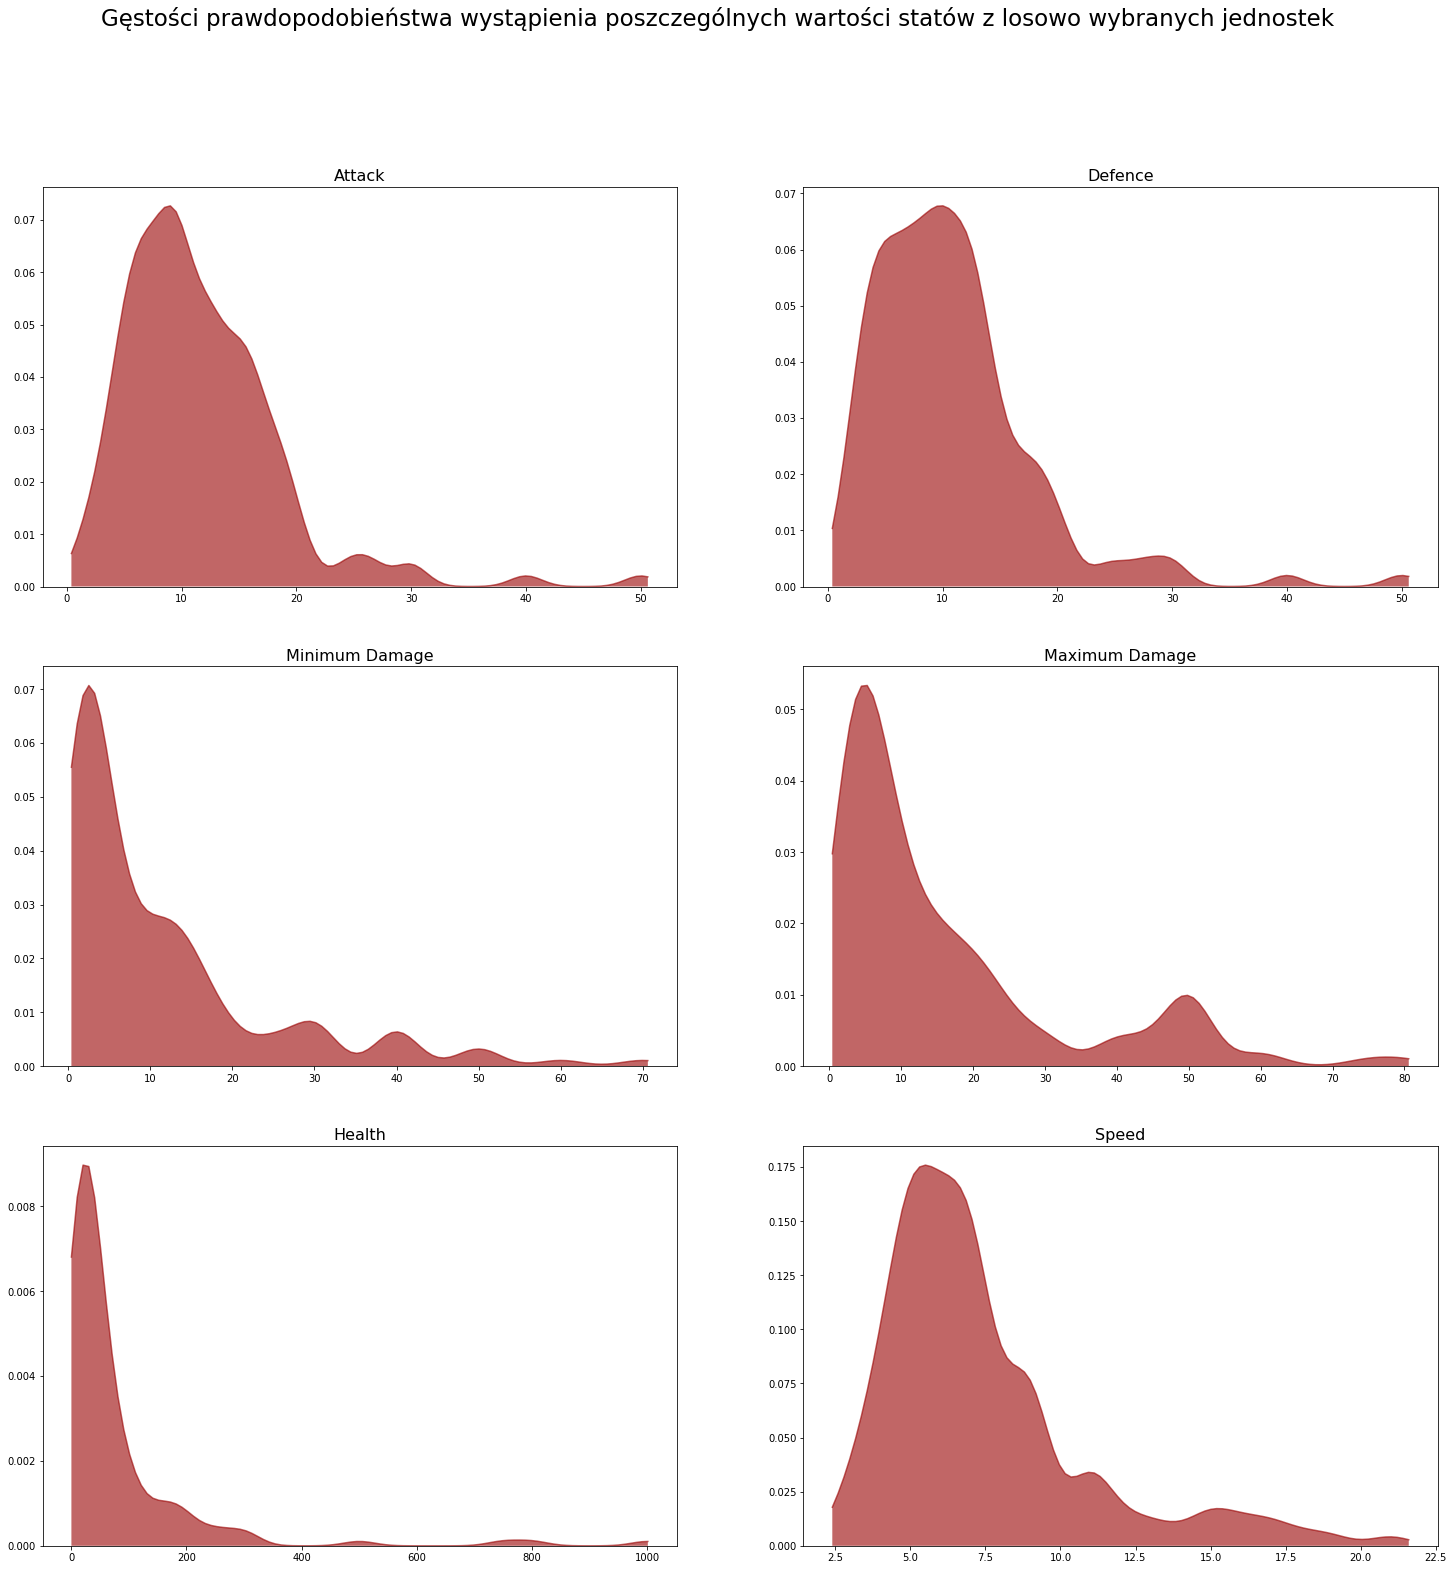

In [57]:
#Dystrybucja #3 - density plot w 1 wymiarze - lepsza wersja histogramu
#Gęstości prawdopodobieństwa wystąpienia poszczególnych wartości statów z losowo wybranych jednostek - czyli de facto wygłądzony histogram wyliczony z kernel density estimation
#Rozmiar 'binów' można modelować za pomocą parametru bw
fig, ax=plt.subplots(3, 2)
fig.set_size_inches(25,25)

for j in range(0, 6, 1):
    fax=ax[j//2][j%2]
    sns.kdeplot(data=df.loc[:,df.columns[3+j]], ax=fax, shade=True, bw=0.2, alpha=0.6, color='#990000')
    fax.set_title(df.columns[3+j], fontsize=16)
    fax.get_legend().remove()
fig.suptitle('Gęstości prawdopodobieństwa wystąpienia poszczególnych wartości statów z losowo wybranych jednostek', fontsize=23)
plt.show()

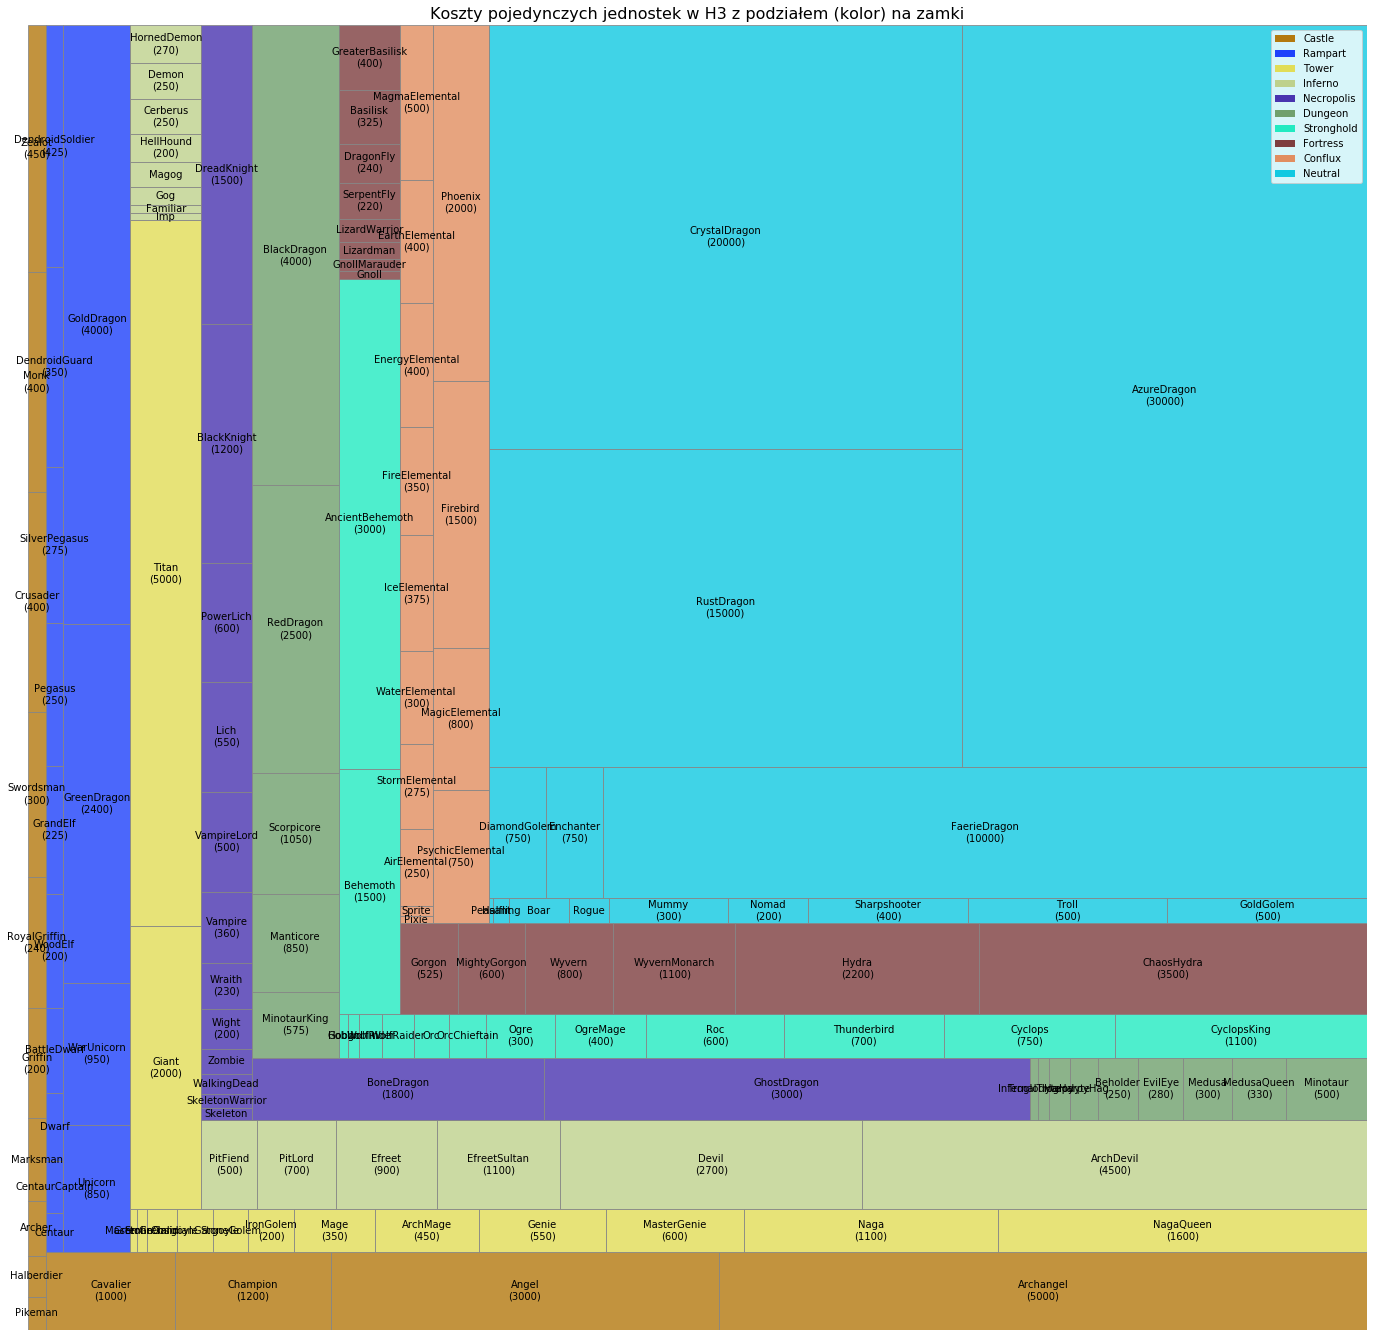

In [63]:
#Część całości #4 - Treeplot - pozwala on (podobnie jak subburst czy dendrogram) analizować w całości zbiory hierarchiczne - z podziałem na podzbiory
#Ten wykres nie jest idealny - byłby taki, gdybym sam sobie implementował funkcję tworzącą treemapę, ale mi się tego nie chce
#Wykres pokazuje porównanie kosztu w złocie dla wszystkich jednostek z podziałem na zamki pomijam koszty tanich jednostek, dzięki temu wykres jest względnie czytelny
#Najciekawszą rzeczą z tego wykresu jest rozrzut między cenami 3 smoków a pozostałych 138 jednostek

#string to int z 2 slotami
def hextodec(a):
    x=0; clr=0; av=1
    L=len(a)
    
    for i in range(L):
        clr=ord(a[L-i-1])
        if (clr>=65):
            clr-=55
        else:
            clr-=48
        x=x+av*clr
        av*=16
    return x

#integer to string z 2 slotami
def dectohex(a):
    l=[0]*2
    
    for i in range(2):
        x=a%16
        if (x<10):
            l[1-i]=chr(x+48)
        else:
            l[1-i]=chr(x+55)
        a=a//16
    return ''.join(l)

#interpolacja kolorów
def colorize(a, b, n):
    l=[0]*n
    d=[0]*3
    a1=[0]*3
    
    for i in range(0,3,1):
        f1=a[1+i*2:3+i*2]
        f2=b[1+i*2:3+i*2]
        a1[i]=f1=hextodec(f1)
        f2=hextodec(f2)
        d[i]=(f2-f1)//n
    
    for i in range(0, n, 1):
        l[i]='#'
        for j in range(0, 3, 1):
            l[i]+=dectohex(a1[j])
            a1[j]+=d[j]
    return l

#Stworzenie 2 randomowych kolorów
def gen_rand_colors(diff):
    if (diff>128):
        diff=128
    l=[0]*3
    l2=[0]*3
    
    for i in range(0,3,1):
        l[i]=l2[i]=np.random.randint(0,256)
    x=np.random.randint(0,3)
    if (l[x]<=255-diff):
        l2[x]=l[x]+diff
    else:
        l2[x]=l[x]-diff
    
    s1='#'; s2='#'
    for i in range(0,3,1):
        s1+=dectohex(l[i])
        s2+=dectohex(l2[i])
    return (s1, s2)



df2=df.copy()
df2['All']=1
df2['Kappa']=df2.index

df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='Kappa')
#print(df2)


fig, ax=plt.subplots(1,1)
fig.set_size_inches(24,24)

clr=[]
lg=[]
Z=df2.columns.get_loc('All')
W=df2.columns.get_loc('Castle')
for i in range(0, df2.shape[0], 1):
    s1, s2=gen_rand_colors(90)
    #clr.extend(colorize(s1, s2, df2.iat[i,Z])) #interpolacja po kolorach - nie polecam, rozmywa się efekt porównania zamków
    clr.extend(colorize(s1, s1, df2.iat[i,Z]))
    lg.append(Patch(facecolor=s1, label=df2.iat[i,W]))
#print(len(clr))

lb=df['Unit_name']+'\n('+df['Gold'].astype(str)+')'
for i in range(0, len(lb), 1):
    if (df.at[i,'Gold']<200):
        lb[i]=df.at[i,'Unit_name']
        
squarify.plot(sizes=df['Gold'], label=lb, alpha=0.8, ax=ax, color=clr, text_kwargs={'fontsize': 10}, bar_kwargs={'fill': True, 'edgecolor': '#888888'})
ax.set_title('Koszty pojedynczych jednostek w H3 z podziałem (kolor) na zamki', fontsize=16)
ax.axis('off')
ax.legend(handles=lg)

plt.show()